In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller, acf

def adf_test(df):
    adfuller_test = adfuller(df, autolag='AIC')[1]
    is_adfuller = lambda x: 1 if x < 0.05 else 0
    adfuller_result = is_adfuller(adfuller_test)
    return adfuller_result

def cycle_test(df):
    import scipy.signal as signal
    acf_values = acf(df, nlags=len(df) - 1)
    loc_max_index = signal.argrelextrema(acf_values, comparator=np.greater, order=3)
    cycle_check = [i for i in loc_max_index[0] if i % 7 == 0]
    is_cycle = lambda x: 1 if cycle_check else 0
    cycle_result = is_cycle(cycle_check)
    return cycle_result

def auto_correlation(x, lag=7):
    if isinstance(x, pd.Series):
        x = x.values
    if len(x) < lag:
        return np.nan
    y1 = x[:(len(x) - lag)]
    y2 = x[lag:]
    x_mean = np.mean(x)
    sum_product = np.sum((y1 - x_mean) * (y2 - x_mean))
    v = np.var(x)
    if np.isclose(v, 0):
        return None
    else:
        return float(sum_product / ((len(x) - lag) * v))

In [3]:
from hts.utilities.load_data import load_hierarchical_sine_data
from datetime import datetime

s, e = datetime(2023, 6, 1), datetime(2023, 7, 31)
hsd = load_hierarchical_sine_data(start=s, end=e, n=10000)
hsd['ds'] = hsd.index.strftime("%Y-%m-%d")
df = hsd.groupby(['ds']).sum().reset_index(drop=False).sort_values(by='ds', ascending=True)

Text(0.5, 1.0, 'a_x_1')

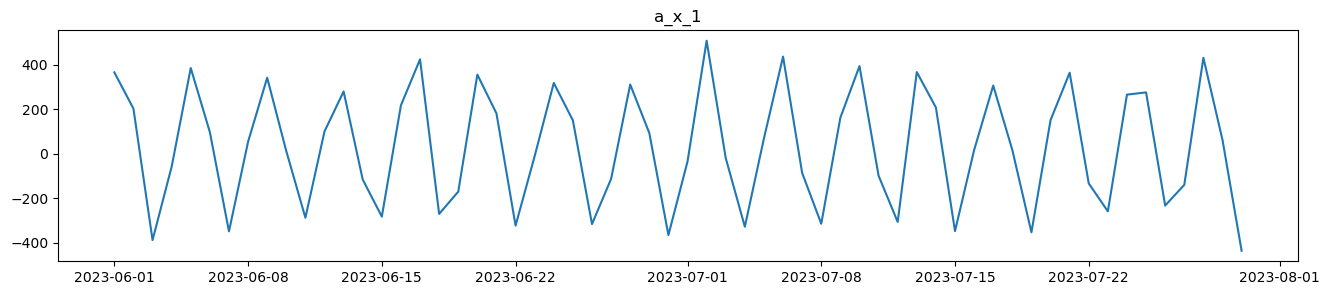

In [4]:
plt.figure(figsize=(16, 3))
plt.plot(pd.to_datetime(df.ds), df.a_x_1)
plt.title('a_x_1')

In [5]:
#predict_datetime = '2023-06-30'
predict_datetime = '2023-07-01'

traindf = df[df['ds']<=predict_datetime]
testdf = df[df['ds']>predict_datetime]

In [6]:
traindf_cols = list(traindf.iloc[:, 0])
traindf_cols.insert(0, 'code')

In [7]:
traindf_tp = pd.DataFrame(traindf.iloc[:, 1:].T).reset_index(drop=False)
traindf_tp.columns = traindf_cols

In [8]:
traindf_tp['qty_list'] = traindf_tp.iloc[:, 1:-2].values.tolist()

In [9]:
from tsfresh.feature_extraction.feature_calculators import *

traindf_tp['adf_30'] = [adf_test(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['cycle_30'] = [cycle_test(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['asc_30'] = [absolute_sum_of_changes(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['corr_30'] = [auto_correlation(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['c3_30'] = [c3(dfi, lag=7) for dfi in traindf_tp['qty_list']]
traindf_tp['ch_qty_30'] = [change_quantiles(dfi, ql=0.2, qh=0.8, isabs=True, f_agg='mean') for dfi in traindf_tp['qty_list']]
traindf_tp['ent_30'] = [approximate_entropy(dfi, m=7, r=0.1) for dfi in traindf_tp['qty_list']]
traindf_tp['cid_30'] = [cid_ce(dfi, True) for dfi in traindf_tp['qty_list']]
traindf_tp['lsd_30'] = [large_standard_deviation(dfi, r=0.2) for dfi in traindf_tp['qty_list']]
traindf_tp['mac_30'] = [mean_abs_change(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['mc_30'] = [mean_change(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['max_30'] = [maximum(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['min_30'] = [minimum(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['mean_30'] = [mean(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['median_30'] = [median(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['std_30'] = [standard_deviation(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['var_30'] = [variance(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['kurt_30'] = [kurtosis(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['skew_30'] = [skewness(dfi) for dfi in traindf_tp['qty_list']]
traindf_tp['rms_30'] = [root_mean_square(dfi) for dfi in traindf_tp['qty_list']]


In [10]:
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor, TabularDataset

predictors = ['adf_30', 'cycle_30', 'asc_30', 'corr_30',
                'c3_30', 'ch_qty_30', 'ent_30', 'cid_30', 'lsd_30', 'mac_30', 'mc_30',
                'max_30', 'min_30', 'mean_30', 'median_30', 'std_30', 'var_30',
                'kurt_30', 'skew_30', 'rms_30']
traindf_tp = TabularDataset(traindf_tp)

X, y = traindf_tp[predictors], traindf_tp[[predict_datetime]]
trainX, testX, trainy, testy = train_test_split(X, y, train_size=0.8, random_state=0)

In [25]:
#predictor = TabularPredictor(label='2023-07-01').fit(pd.concat([trainX, trainy], axis=1))
save_path='./AutogluonModels/ag-20230708_151430'
predictor = TabularPredictor.load(save_path)

In [28]:
predictions = predictor.predict(testX)
#predictor.leaderboard(pd.concat([testX, testy], axis=1), silent=True)
predictions

20    -43.854729
10    -61.061428
14    -34.853165
13    -30.345020
1    -164.115891
Name: 2023-07-01, dtype: float32

In [22]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(trainX, trainy)
predy = model.predict(testX)

In [23]:
predict_result = testy
predict_result['predy'] = model.predict(testX)
predict_result['automl'] = predictions
predict_result['acc1'] = 1 - abs(predict_result[predict_datetime]-predict_result['predy'])/abs(predict_result[predict_datetime])
predict_result['acc2'] = 1 - abs(predict_result[predict_datetime]-predict_result['automl'])/abs(predict_result[predict_datetime])

In [24]:
predict_result

,2023-07-01,predy,automl,acc1,acc2
20,-84.742662,-48.569380,-43.854729,0.573140,0.517505
10,-34.838155,-50.776935,-61.061428,0.542491,0.247283
14,-65.765846,-27.008024,-34.853165,0.410669,0.529958
13,-34.379567,-26.746545,-30.345020,0.777978,0.882647
1,-183.668138,-147.221278,-164.115891,0.801561,0.893546
